In [1]:
import numpy as np
import xarray as xr
from xgcm import Grid
from matplotlib import pyplot as plt
import dask
import cmocean
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

%matplotlib inline

In [2]:
from distributed import Client, progress, LocalCluster
import socket

client = Client(service_kwargs={'dashboard': {'prefix': f'/node/{socket.gethostname()}/8787'}})

In [3]:
client

Client Scheduler: tcp://127.0.0.1:46129 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 137.44 GB


In [4]:
#files = glob('/srv/scratch/z3533156/20year_run_tide/outer_dia/outer_dia_*.nc')
filelist=[]
for files in glob('/srv/scratch/z3533156/20year_run_tide/outer_dia/outer_dia_0[1-9]*.nc'): 
    #print(files)
    filelist.append(files)
#files = glob('/scratch/fu5/cgk561/eac/20year_freerun_NEW/output_heatbudget/outer_dia_01*.nc')
# A basic chunk choice
chunks = {'ocean_time':1}

diag = xr.open_mfdataset(filelist, chunks=chunks, data_vars='minimal',compat='override',coords='minimal',parallel=True)

#files = glob('/srv/scratch/z3533156/20year_run_tide/outer_avg/outer_avg_*.nc')
filelist=[]
for files in glob('/srv/scratch/z3533156/20year_run_tide/outer_avg/outer_avg_0[1-9]*.nc'): 
    #print(files)
    filelist.append(files)
#files = glob('/scratch/fu5/cgk561/eac/20year_freerun_NEW/output_heatbudget/outer_avg_01*.nc')

ds = xr.open_mfdataset(filelist, chunks=chunks, data_vars='minimal',compat='override',coords='minimal',parallel=True)

## Creating a grid object
While xgcm doesn't currently have an implementation for the SGRID convention for ROMS, a workaround consist on renaming eta_u and xi_v dimensions to rho. With this replacement 'psi' points have now a position (eta_v, xi_u). See issue here https://github.com/xgcm/xgcm/issues/108
Here I also test to see if the new XGCM 'metrics' functionality works.

In [5]:
# Including metrics
ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}}

grid = Grid(ds, coords=coords, periodic=[])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')


ds['pm_v'] = grid.interp(ds.pm, 'Y')
ds['pn_u'] = grid.interp(ds.pn, 'X')
ds['pm_u'] = grid.interp(ds.pm, 'X')
ds['pn_v'] = grid.interp(ds.pn, 'Y')
ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

ds['dx'] = 1/ds.pm
ds['dx_u'] = 1/ds.pm_u
ds['dx_v'] = 1/ds.pm_v
ds['dx_psi'] = 1/ds.pm_psi

ds['dy'] = 1/ds.pn
ds['dy_u'] = 1/ds.pn_u
ds['dy_v'] = 1/ds.pn_v
ds['dy_psi'] = 1/ds.pn_psi

ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
ds['dz_u'] = grid.interp(ds.dz, 'X')
ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
ds['dz_v'] = grid.interp(ds.dz, 'Y')
ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

ds['dA'] = ds.dx * ds.dy

metrics = {
    ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
    ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
    ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
    ('X', 'Y'): ['dA'] # Areas
}
grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

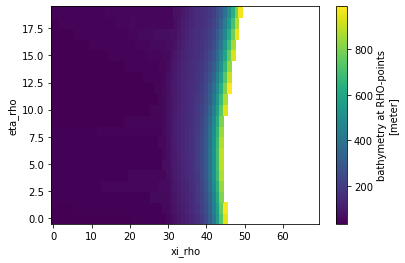

In [6]:
h_shelf = ds.h.where(ds.h<1000)
h_shelf.isel(eta_rho=slice(100, 120),xi_rho=slice(35, 105)).plot()

In [7]:
edge = np.empty(shape=(316), dtype=int)
for x in range(0, 316):
    a = np.isnan(h_shelf[x,:]).argmax()
    edge[x]=a

## define transports and convert to Sv

In [8]:
#first need to interpolate h to edges of grid box
h_U = grid.interp(ds.h, axis='X')
h_V = grid.interp(ds.h, axis='Y')

ds['U_trspt'] = ((ds.ubar*ds.dy_u*h_U)/1e6)
ds['V_trspt'] = ((ds.vbar*ds.dx_v*h_V)/1e6)

## How does bathymetry factor in? Lets look at PV

In [ ]:
ds.bvstr

In [ ]:
bottom_pvor_mean = ds.pvorticity_bar.mean('ocean_time')

In [ ]:
fig = plt.figure(figsize=(12,7))
plt.subplot(121)
bottom_pvor_mean.plot()
ds.h.plot.contour(levels=[1000], colors='black')
plt.subplot(122)
bottom_pvor_mean.mean('xi_u').plot(y='eta_v')
plt.savefig('P_vor_bar_22yr.png',dpi=300)

In [ ]:
bot_stress_y = grid.interp(ds.bvstr,'Y',boundary='fill').where(ds.h<1000)
bot_stress_y

In [ ]:
fig = plt.figure(figsize=(12,7))
plt.subplot(121)
bot_stress_y.mean('ocean_time').plot.contourf(cbar_kwargs=dict(orientation='vertical',
                      pad=0.15, shrink=1, label='bottom stress Nm$^{-2}$'))

ds.h.plot.contour(levels=[1000], colors='black')
plt.subplot(122)
bot_stress_y.mean('ocean_time').mean('xi_rho').plot(y='eta_rho')
plt.grid(True)
plt.xlabel('Nm$^{-2}$')
plt.savefig('y_bottomstress_22yr_map.png',dpi=300)

In [ ]:
fig = plt.figure(figsize=(12,7))
latmin=25*-1
latmax=40*-1

#set coastline
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

#plot
ax = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
bot_stress_y.mean('ocean_time').plot.contourf('lon_rho','lat_rho',projection=ccrs.PlateCarree(),cbar_kwargs=dict(orientation='vertical',
                      pad=0.15, shrink=1, label='bottom stress Nm$^{-2}$'))
ax.set_extent([148,155,latmin,latmax])
#ds.temp[:,-1,:,:].mean(dim='ocean_time').plot.contourf('lon_rho', 'lat_rho', ax=ax,cbar_kwargs={'label': 'SST [ $^o$C ]'},
#                                          extend = 'both',cmap=cmocean.cm.thermal)
z = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='black',levels=[0,1000])
#make pretty gridlines and labels
gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False

plt.subplot(122)
bot_stress_y.mean('ocean_time').mean('xi_rho').plot(y='eta_rho')
plt.grid(True)
plt.xlabel('Nm$^{-2}$')
plt.savefig('y_bottomstress_22yr_map.png',dpi=300)

In [ ]:
#save out to .nc for correlations
#bot_stress_y.mean('xi_rho').load().to_netcdf('/srv/scratch/z3526974/X_shelf_exchange/Shelf_bvstr_le_1000m_Barra_22yr.nc')

In [ ]:
bot_stress_x = grid.interp(ds.bustr,'X',boundary='fill').where(ds.h<1000)
bot_stress_x

In [ ]:
fig = plt.figure(figsize=(12,7))
plt.subplot(121)
bot_stress_x.mean('ocean_time').plot(cbar_kwargs=dict(orientation='vertical',
                      pad=0.15, shrink=1, label='bottom stress Nm$^{-2}$'))

ds.h.plot.contour(levels=[1000], colors='black')
plt.subplot(122)
bot_stress_x.mean('ocean_time').mean('xi_rho').plot(y='eta_rho')
plt.xlabel('Nm$^{-2}$')
plt.savefig('x_bottomstress_22yr.png',dpi=300)

### Calculate northward and southward transport out to the shelf for each row of cells

The residual of this is the cross-shelf transport

In [9]:
#trspt_S=[]
trspt_N=[]

for i in range(0,315):
   # V_s =(ds.V_trspt.isel(xi_rho=slice(0,edge[i]-1),eta_v=i)).sum(dim='xi_rho',skipna=True)
    V_n = ((ds.V_trspt.isel(xi_rho=slice(0,edge[i]-1),eta_v=i+1))).sum(dim='xi_rho',skipna=True)*-1
    #trspt_S.append(V_s)
    trspt_N.append(V_n)

    
#V_s = xr.concat(trspt_S, dim='eta')
V_n = xr.concat(trspt_N, dim='eta')

In [12]:
V_n

<xarray.DataArray 'V_trspt' (eta: 315, ocean_time: 8308)>
dask.array<concatenate, shape=(315, 8308), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 1994-01-02 1994-01-03 ... 2016-09-30
Dimensions without coordinates: eta

In [13]:
#ds['V_s']=V_s.load()
ds['V_n']=V_n#.load()
#ds['V_nm1'] = -ds.V_n.shift(eta=1) # Not sure of signs or shift direction - but I get a better match below??

In [ ]:
ds.V_n.to_netcdf('/srv/scratch/z3526974/X_shelf_exchange/Shelf_V_n_1000m_Barra_22yr_full.nc')

In [ ]:
#ds['x_shelf_trspt'] = ds.V_n + ds.V_s
ds['x_shelf_trsptB'] = ds.V_n + ds.V_nm1

#add latitude as a coordinate for easy plotting
#ds['x_shelf_trspt'] = ds.x_shelf_trspt.assign_coords(latitude=('eta',(ds.lat_rho.isel(xi_rho=50)[0:315])))
ds['x_shelf_trsptB'] = ds.x_shelf_trsptB.assign_coords(latitude=('eta',(ds.lat_rho.isel(xi_rho=50)[0:315])))

#plot
#ds.x_shelf_trspt.mean(dim='ocean_time').plot(y='latitude')
ds.x_shelf_trsptB.mean(dim='ocean_time').plot(y='latitude')

# The orange line might look a bit weird below - but I think it might still make sense. 
# There are lots of regions of onshore and then offshore altertnating flows if you take account of Vn and Vs properly.
# It looks much better in terms of a cumulative plot (see the second figure).

In [ ]:
# Coarsen and plot
U_x200 = ds.x_shelf_trsptB.cumsum('eta').coarsen(eta=23,boundary='trim').mean()
U_x200.mean('ocean_time').plot(y='latitude')

In [ ]:
#ds.x_shelf_trspt.cumsum('eta').mean(dim='ocean_time').plot(y='latitude')
fig = plt.figure(figsize=(8,8))
ds.x_shelf_trsptB.cumsum('eta').mean(dim='ocean_time').plot(y='latitude')
#plt.savefig('X_shelf_trans_mean_1000m_1994-2016.png')

In [ ]:
ds.V_n.isel(eta=0).mean(dim='ocean_time')

In [ ]:
ds.V_nm1.isel(eta=1).mean(dim='ocean_time')

In [ ]:
fig = plt.figure(figsize=(12,6))
ds.x_shelf_trsptB.cumsum('eta').plot(y='latitude')
plt.savefig('X_shelf_trans_hovmoller_1000m_1994_2016.png')

In [ ]:
X_shelf_anomalies=ds.x_shelf_trsptB.cumsum('eta') - ds.x_shelf_trsptB.cumsum('eta').mean(dim='ocean_time')

In [ ]:
fig = plt.figure(figsize=(12,6))
X_shelf_anomalies.plot(y='latitude')
plt.savefig('X_shelf_trans_anomalies_hovmoller_1000m_1994_2016.png')

In [ ]:
ds.x_shelf_trsptB.plot.contourf(y='latitude', vmin=-0.5)

In [ ]:
ds.x_shelf_trsptB.sum(dim='eta').plot()

In [ ]:
inflow = ds.V_n.isel(eta=-1)
outflow = ds.V_n.isel(eta=0)
(inflow-outflow).plot(linestyle='--')
ds.x_shelf_trsptB.sum(dim='eta').plot(label='Xshelf residual')

In [ ]:
fig = plt.figure(figsize=(12,7))
latmin=25*-1
latmax=40*-1

#set coastline
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

#plot
ax = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
ax.set_extent([148,156,latmin,latmax])
#ds.temp[:,-1,:,:].mean(dim='ocean_time').plot.contourf('lon_rho', 'lat_rho', ax=ax,cbar_kwargs={'label': 'SST [ $^o$C ]'},
#                                          extend = 'both',cmap=cmocean.cm.thermal)
z = ds.h.isel(ocean_time=0).plot.contour(x='lon_rho',y='lat_rho',colors='black',levels=[0,1000])
#make pretty gridlines and labels
gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False

#add geostrophic current arrows
u=grid.interp(ds.ubar.mean('ocean_time'),axis='X',boundary='fill')
v=grid.interp(ds.vbar.mean('ocean_time'),axis='Y',boundary='fill')
lat = ds.lat_rho
lon = ds.lon_rho
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(lon[skip],lat[skip],u[skip],v[skip])



plt.subplot(1,2,2)
(ds.x_shelf_trsptB).cumsum('eta').mean(dim='ocean_time').plot(y='latitude')
plt.ylim((latmax, latmin))

#plt.savefig('X_shelf_trans1000_mean_spatial_1994_2016.png')